In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.lines as mlines
import locale

Datenaufbereitung


In [3]:
df_price = (
    pd.read_excel("./../../data/Preise.xlsx")
        .rename(columns={"Jahr": "year",
                         "preis": "price"})
        .assign(year=lambda _data: pd.to_numeric(_data["year"].str.strip('"')))
        .replace([20022, "Tablet Basics"],[2022, "Tablet Basic"])
)

df_dt = (
    pd.read_excel("./../../data/Downtime.xlsx")
        .rename(columns={"Unnamed: 0": "year",
                         "Region A": "a",
                         "Region B": "b",
                         "Region C": "c",
                         "Region D": "d"})
)

df_crm = (
    pd.read_excel("./../../data/CRM_data.xlsx")
        .rename(columns={"id": "transaction_id",
                         "vorname": "firstname",
                         "nachname": "lastname"})
)

def read_regio_data(region, kind): 
    return (pd.read_excel(f"./../../data/Region{region}_{kind}.xlsx")
                .rename(columns={"Tablet Basic": "basic",
                                "Tablet Mini": "mini",
                                "Tablet Pro": "pro",
                                "kosten_mini": "cost_mini",
                                "kosten_basic": "cost_basic",
                                "kosten_pro": "cost_pro",
                                "PRODUKT": "product"})
                .assign(year=lambda _data: _data["date"].dt.year,
                        month=lambda _data: _data["date"].dt.month,
                        week=lambda _data: _data["date"].dt.isocalendar().week,
                        year_month=lambda _data: _data["date"].dt.year.astype(str) + "_" + _data["date"].dt.month.astype(str),
                        cost_basic=lambda _data: np.round(_data["cost_basic"], 2),
                        cost_mini=lambda _data: np.round(_data["cost_mini"], 2),
                        cost_pro=lambda _data: np.round(_data["cost_pro"], 2),
                        cost_per_unit=lambda _data: _data["cost_basic"].fillna(0) + _data["cost_mini"].fillna(0) + _data["cost_pro"].fillna(0),
                        cost=lambda _data: _data["cost_per_unit"] * _data["amount"]
                        )
                .merge(df_price, on=["year", "product"])
                .assign(revenue=lambda _data: _data["price"] * _data["amount"],
                        profit_per_unit=lambda _data: _data["price"] - _data["cost_per_unit"],
                        profit=lambda _data: _data["profit_per_unit"] * _data["amount"])
                .merge(df_crm[["customer_rating", "email", "transaction_id"]], on="transaction_id"))


df_regAo = read_regio_data("A","online")
df_regAp = read_regio_data("A","phone")
df_regAs = read_regio_data("A","store")
df_regBo = read_regio_data("B","online")
df_regBp = read_regio_data("B","phone")
df_regBs = read_regio_data("B","store")
df_regCo = read_regio_data("C","online")
df_regCp = read_regio_data("C","phone")
df_regCs = read_regio_data("C","store")
df_regDo = read_regio_data("D","online")
df_regDp = read_regio_data("D","phone")
df_regDs = read_regio_data("D","store")

# Array mit Zuordnung der DataFrames zu Region und Marketplace
dataframes = [
    (df_regAo, 'A', 'online'),
    (df_regAp, 'A', 'phone'),
    (df_regAs, 'A', 'store'),
    (df_regBo, 'B', 'online'),
    (df_regBp, 'B', 'phone'),
    (df_regBs, 'B', 'store'),
    (df_regCo, 'C', 'online'),
    (df_regCp, 'C', 'phone'),
    (df_regCs, 'C', 'store'),
    (df_regDo, 'D', 'online'),
    (df_regDp, 'D', 'phone'),
    (df_regDs, 'D', 'store')
]

# Spezifisiche Region und Marktplatz zu jedem Frame hinzufügen
for df_reg_main, region, marketplace in dataframes:
    df_reg_main['region'] = region
    df_reg_main['marketplace'] = marketplace

# Alle DataFrames zusammenfügen (concat)
# ignore_index=True: Index wird neu erstellt
df_reg_main = pd.concat([df for df, _, _ in dataframes], ignore_index=True)

In [4]:
df_reg_main.head()

,date,product,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,...,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating,email,region,marketplace
0,2021-11-01,Tablet Basic,1.0,5,1,0,0,170.02,NaN,NaN,...,170.02,850.10,529,2645,358.98,1794.90,7.1,friedhilde.kuhl@yahoo.de,A,online
1,2021-11-01,Tablet Basic,1.0,7,1,0,0,170.02,NaN,NaN,...,170.02,1190.14,529,3703,358.98,2512.86,5.9,heide-marie.fischer@gmx.de,A,online
2,2021-11-01,Tablet Basic,0.9,7,1,0,0,210.03,NaN,NaN,...,210.03,1470.21,529,3703,318.97,2232.79,7.5,ester.pruschke@gmail.com,A,online
3,2021-11-01,Tablet Basic,1.0,10,1,0,0,170.08,NaN,NaN,...,170.08,1700.80,529,5290,358.92,3589.20,6.6,klaus.blümel@aol.de,A,online
4,2021-11-01,Tablet Basic,1.0,4,1,0,0,170.09,NaN,NaN,...,170.09,680.36,529,2116,358.91,1435.64,7.3,waldemar.fritsch@web.de,A,online


In [5]:
# Create a custom formatter function for the y-axis
def millions_formatter(x, pos):
    return "%1.1f Mio." % (x * 1e-6)


# Generic formatting for lineplot
def format_lineplot():
    # Define the plot size
    # plt.figure(figsize=(10, 6))

    # Set the locale to German to ensure month names are in German
    locale.setlocale(locale.LC_TIME, "de_DE.utf8")

    # Create a MonthLocator object to ensure ticks are set at monthly intervals
    locator = mdates.MonthLocator()

    # Set the locator for the x-axis
    plt.gca().xaxis.set_major_locator(locator)

    # Format x-axis with German months in abbreviated form and year
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))

    # Optionally, set the x-tick labels rotation
    plt.xticks(rotation=45)

    # Set the starting point of the y-axis to 0
    plt.gca().set_ylim(bottom=0)

    # Remove the y-axis and x-axis label
    plt.gca().set_ylabel("")
    plt.gca().set_xlabel("")

    # Add grid lines for better readability
    plt.grid(which="both", axis="both", linestyle="--", linewidth=0.5)


def format_lineplot2(ax):
    # Set the locale to German to ensure month names are in German
    locale.setlocale(locale.LC_TIME, "de_DE.utf8")

    # Create a MonthLocator object to ensure ticks are set at monthly intervals
    locator = mdates.MonthLocator()

    # Set the locator for the x-axis
    ax.xaxis.set_major_locator(locator)

    # Format x-axis with German months in abbreviated form and year
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))

    # Optionally, set the x-tick labels rotation
    ax.tick_params(axis="x", rotation=45)

    # Set the starting point of the y-axis to 0
    ax.set_ylim(bottom=0)

    # Remove the y-axis and x-axis label
    ax.set_ylabel("")
    ax.set_xlabel("")

    # Add grid lines for better readability
    ax.grid(which="both", axis="both", linestyle="--", linewidth=0.5)

In [17]:
df_pro = df_reg_main[df_reg_main["product"] == "Tablet Pro"]
#df_stores_basic_pro = df_stores[df_stores["product"].isin(["Tablet Basic", "Tablet Pro"])]

C:\Users\timst\AppData\Local\Temp\ipykernel_13848\2839661114.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df, x="date", y="amount", palette="husl")


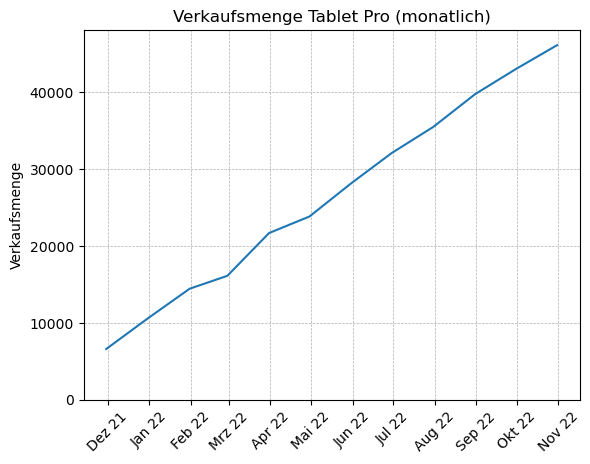

In [21]:

df = (
    df_pro.groupby([pd.Grouper(key="date", freq="1M"), "product"])
    .agg({"amount": "sum"})
    .reset_index()
)


sns.lineplot(data=df, x="date", y="amount", palette="husl")
# sns.lineplot(data=df, x="date", y="revenue", label="Umsatz")
# sns.lineplot(data=df, x="date", y="cost", label="Kosten")

format_lineplot()
#min_profit = df["profit"].min()
#plt.gca().set_ylim(bottom=min_profit + min_profit * 10)

#plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
plt.title("Verkaufsmenge Tablet Pro (monatlich)")

plt.gca().set_ylabel("Verkaufsmenge")

plt.show()

C:\Users\timst\AppData\Local\Temp\ipykernel_13848\3309300925.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df, x="date", y="profit/amount", palette="husl", label="Gewinn p. Stück")
C:\Users\timst\AppData\Local\Temp\ipykernel_13848\3309300925.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df, x="date", y="cost/amount", palette="husl", label="Kosten p. Stück")
C:\Users\timst\AppData\Local\Temp\ipykernel_13848\3309300925.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df, x="date", y="revenue/amount", palette="husl", label="Umsatz p. Stück")


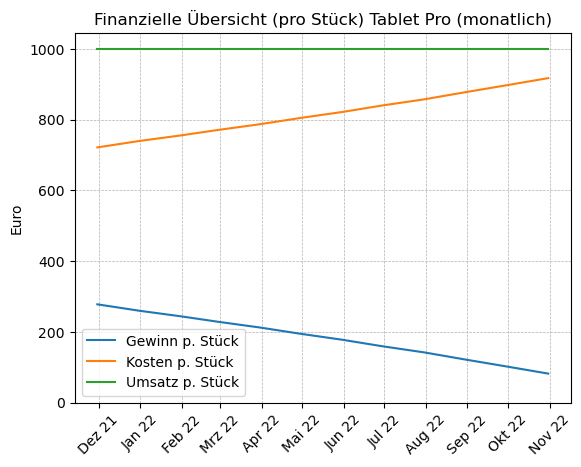

In [38]:
df = (
    df_pro.groupby([pd.Grouper(key="date", freq="1M"), "product"])
    .agg({"profit": "sum", "amount": "sum", "cost": "sum", "revenue": "sum", "price": "mean"})
    .reset_index()
)

df["profit/amount"] = df["profit"] / df["amount"]
df["cost/amount"] = df["cost"] / df["amount"]
df["revenue/amount"] = df["revenue"] / df["amount"]


sns.lineplot(data=df, x="date", y="profit/amount", palette="husl", label="Gewinn p. Stück")
sns.lineplot(data=df, x="date", y="cost/amount", palette="husl", label="Kosten p. Stück")
sns.lineplot(data=df, x="date", y="revenue/amount", palette="husl", label="Umsatz p. Stück")
# sns.lineplot(data=df, x="date", y="price", style="product", palette="husl")
# sns.lineplot(data=df, x="date", y="price", style="product", palette="husl")


format_lineplot()
#min_profit = df["profit/amount"].min()
#plt.gca().set_ylim(bottom=min_profit + min_profit * 0.2)

# plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
# plt.title("Finanzielle Übersicht: Gesamt")
plt.title("Finanzielle Übersicht (pro Stück) Tablet Pro (monatlich)")
plt.gca().set_ylabel("Euro")



plt.show()